In [1]:
import math
import numpy as np
from math import e
from matplotlib import pyplot as plt
from typing import Callable
import random
import pandas as pd
from scipy.stats import norm

$$1.\; Prep work$$

a) Evaluate I analytically (type your solution in LaTeX)

$\int_a^bf(20-x^2)dx = 20x - \frac{x^3}{3}$

$I = [20b - \frac{b^3}{3}] - [20a - \frac{a^3}{3}]$

$I = 20b - \frac{b^3}{3} - 20a + \frac{a^3}{3}$

b) Create a Python function for $f$ with signature

f(x: float) → float

In [2]:
def f(x: float):
    return (20 - x**2)

c) Create a Python function that evaluates the analytical solution to $I$ from a), with signature

I(a: float, b: float) → float

In [3]:
def I(a: float, b: float):
    return (20*b) - ((b**3) / 3) - (20 * a) + ((a**3) / 3)
integral_true = I(-1,3)

I(-1,3)

70.66666666666667

$$2.\; Basic\; Monte\; Carlo$$

a) What is $\mathbb{E}p[I_n^{basic}]$?

$\mathbb{E}p[I_n] = \mathbb{E}[\frac{1}{n}\sum\limits_{i=1}^n f(x_i) (b - a)]$

$= \frac{1}{n} \cdot (b-a) \cdot \sum\limits_{i=1}^n \mathbb{E}[f(x_i)] $

$= (b-a) \int_{x \in D} f(x)p(x)dx$

$= (b-a)\int_a^b f(x)\frac{1}{b-a}dx$

$= \int_a^b f(x)dx$

$= I$

b) Create a function to compute $I_n^{basic}$ over an interval $a$, $b$ for number of samples $n$. The function signature should be:

mc_basic(f: Callable[[float], float], a: float, b: float, n: int) → tuple[float, float]

In [4]:
def mc_basic(f: Callable[[float], float], a: float, b: float, n: int) -> tuple[float, float]:
    sum_i_basic = 0
    sum_i_basic_squared = 0
    term_list = []
    for _ in range(n):
        xi = random.uniform(a, b)
        term = f(xi) * (b - a)
        term_list.append(term)
        sum_i_basic += term
        sum_i_basic_squared += term ** 2

    i_basic = sum_i_basic / n

    print(i_basic)
    var_i_basic = np.var(term_list) / n #(sum_i_basic_squared / n - (i_basic) ** 2) / n

    return i_basic, var_i_basic

def f(x: float):
    return (20 - x**2)

a = -1
b = 3
n = 100000

result, variance = mc_basic(f, a, b, n)

print("I_n^basic =", result)
print("Var(I_n^basic) =", variance)


70.60265607881868
I_n^basic = 70.60265607881868
Var(I_n^basic) = 0.0010869485142127162


c) Normally we don’t have tractable solutions for the true variance of an estimator when doing Monte Carlo (we’d have to estimate it). However, 
this problem is simple enough where we can derive it.

$Var(I_n^{basic}) = \frac{1}{n} Var(\frac{f(x_i)}{p(x_i)})$

$= \frac{1}{n}[(b-a)E[f(x)^2]-[Ef(x)]^2] $

$= \frac{1}{n}[(b-a)(\int_a^b(400-40x^2+x^4)-(\int_a^b20-x^2)^2)] $

$= \frac{1}{n}[(b-a)(400b-\frac{40b^3}{3}+\frac{b^5}{5}-400a+\frac{400a^3}{3}-\frac{a^5}{5}) - (20b-\frac{20b^3}{3}-20a+\frac{a^3}{3})^2]$

$= \frac{1}{n}[(b-a)(400(b-a)-\frac{40(b^3-a^3)}{3}+\frac{b^5-a^5}{5})-(20(b-a)-\frac{(b^3-a^3)}{3})]$

d) Create a function for the true variance of the basic estimator. It should have signature

mc_basic_variance_true(a: float, b: float, n: int) → float

In [24]:
def var(a: float, b: float, n: float):
    t1 = (b-a)*(400*(b-a) - (40*(b**3 - a**3)/3) + (b**5-a**5)/5)
    t2 = ((20*(b-a)) - ((b**3 - a**3)/3))**2
    ans = (t1 - t2)* 1/n
    
    return ans
true_sigma = var(-1,3,100000)
true_sigma

0.0010808888888888851

e) Using $I_n^{basic}$, $n = 100000$ samples, $a = 1-$ and $b = 3$ report the following metrics in a pandas DataFrame object.

In [6]:
idx = ["Basic"]
data_basic = {'integral_true': [integral_true],
        'integral_estimate': [result],
        'difference': [integral_true - result],
        'sigma^2_estimate/n': [variance],
        'sigma^estimate': [variance*n],
        'sigma^2_true/n': [true_sigma],
        'sigma^2_true': [true_sigma*n]
        }
df_basic = pd.DataFrame(data_basic, idx)


print(df_basic)

       integral_true  integral_estimate  difference  sigma^2_estimate/n  \
Basic      70.666667          70.602656    0.064011            0.001087   

       sigma^estimate  sigma^2_true/n  sigma^2_true  
Basic      108.694851        0.001081    108.088889  


$$3.\; Antithetic\; uniform\; samples$$

a) What is $\mathbb{E}p[I_n^{Antithetic}]$?

$y = \frac{f(x_i)+f(x'_i)}{2}$

$\mathbb{E}[\frac{f(x_i)+f(x'_i)}{2}] $

$=\mathbb{E}[f(x)]$

$f(x'_i)$

b) Create a function to compute $I_n^{Antithetic}$ over an interval $a$, $b$ for number of samples $n$. The function signature should be:

In [7]:
from typing import Callable
import random

def mc_antithetic(f: Callable[[float], float], a: float, b: float, n: int):
    sum_i_antithetic = 0
    sum_i_antithetic_squared = 0

    for _ in range(n //2):
        xi = random.uniform(a, b)
        xip = a + b - xi
        term_antithetic = (f(xi) * (b - a)) + (f(xip) * (b - a))
        sum_i_antithetic += term_antithetic / 2
        sum_i_antithetic_squared += (term_antithetic/2) ** 2

    i_antithetic = sum_i_antithetic * 2 / n  
    var_i_antithetic = (sum_i_antithetic_squared *2/ n - (i_antithetic) ** 2) *2/ n

    return i_antithetic, var_i_antithetic

def f(x: float):
    return (20 - x**2)

a = -1
b = 3
n = 100000

result_antithetic, variance_antithetic = mc_antithetic(f, a, b, n)

print("I_n^antithetic =", result_antithetic)
print("Var(I_n^antithetic) =", variance_antithetic)

I_n^antithetic = 70.62277242605724
Var(I_n^antithetic) = 0.00046019540580777177


c) Using $I_n^{Antithetic}$, $n = 100000$ samples, $a = 1-$ and $b = 3$ report the following metrics in a pandas DataFrame object.

In [8]:
idx = ["Basic","Antithetic"]
data_antithetic = {'integral_true': [integral_true, integral_true],
        'integral_estimate': [result, result_antithetic],
        'difference': [integral_true - result, integral_true - result_antithetic],
        'sigma^2_estimate/n': [variance, variance_antithetic],
        'sigma^estimate': [variance*n, variance_antithetic*n],
        }
df_antithetic = pd.DataFrame(data_antithetic, idx)


print(df_antithetic)

            integral_true  integral_estimate  difference  sigma^2_estimate/n  \
Basic           70.666667          70.602656    0.064011            0.001087   
Antithetic      70.666667          70.622772    0.043894            0.000460   

            sigma^estimate  
Basic           108.694851  
Antithetic       46.019541  


d) How do your results compare to the basic estimate? Is this what you expect?

I_n^antithetic is slightly closer

$$4.\; Control\; Variate$$

a) What is $\mathbb{E}p[I_n^{ComtrolVariate}]$?

$I = \int_{x \in D}f(x)dx$

$= \int_{x \in D}(f(x)-h(x))dx+\int_{x \in D}h(x)dx$

$= \int_{x \in D}(f(x)-h(x))dx+H$

$I_n=\frac{1}{n}\sum\limits_{i=1}^n \frac{f(x_i)-h(x_i)}{p(x_i)}+H$

$\mathbb{E}[I_n]=I$

b) Implement functions for the control variates and their integrals

In [9]:
def h1(x: float):
    return 20 * np.cos(x / 3)

def h2(x: float):
    return 20 * np.sin(x / 3)

def H1(a: float, b: float):
    return (20 * 3 * np.sin(b / 3)) - (20 * 3 * np.sin(a / 3))

def H2(a: float, b: float):
    return (-20 * 3 * np.cos(b / 3)) - (-20 * 3 * np.cos(a / 3))



c) Create a function to compute $I_n^{Control Variate}$ over an interval $a$, $b$ for number of samples $n$. The function signature should be:

In [10]:
def mc_control_variate1(f: Callable[[float], float], a: float, b: float, n: int, h: Callable[[float], float], H: Callable[[float, float], float]):
    sum_i_control_variate = 0
    sum_i_control_variate_squared = 0
    term_list1 = []

    for _ in range(n):
        xi = random.uniform(a, b)
        term = (f(xi) - h1(xi)) * (b - a) + H1(a, b)
        term_list1.append(term)
        sum_i_control_variate += term
        sum_i_control_variate_squared += term ** 2

    i_control_variate_1 = sum_i_control_variate / n  

    
    var_i_control_variate_1 = np.var(term_list1) #(sum_i_control_variate_squared / n - (i_control_variate) ** 2) / n

    return i_control_variate_1, var_i_control_variate_1



a = -1
b = 3
n = 100000
h = h1
H = H1

result_control_variate_1, variance_control_variate_1 = mc_control_variate1(f, a, b, n, h, H)

print("I_n^_control_variate =", result_control_variate_1)
print("Var(I_n^_control_variate) =", variance_control_variate_1)


I_n^_control_variate = 70.66801945020335
Var(I_n^_control_variate) = 0.20254091433107949


In [11]:
from typing import Callable
import random

def mc_control_variate(f: Callable[[float], float], a: float, b: float, n: int, h: Callable[[float], float], H: Callable[[float, float], float]):
    sum_i_control_variate = 0
    sum_i_control_variate_squared = 0
    term_list2 = []

    for _ in range(n):
        xi = random.uniform(a, b)
        term2 = (f(xi) - h2(xi)) * (b - a) + H2(a, b)
        term_list2.append(term2)
        sum_i_control_variate += term2
        sum_i_control_variate_squared += term2 ** 2

    i_control_variate_2 = sum_i_control_variate / n  

    
    var_i_control_variate_2 = np.var(term_list2) / n #(sum_i_control_variate_squared / n - (i_control_variate) ** 2) / n

    return i_control_variate_2, var_i_control_variate_2

a = -1
b = 3
n = 100000
h = h2
H = H2

result_control_variate_2, variance_control_variate_2 = mc_control_variate(f, a, b, n, h, H)

print("I_n^_control_variate =", result_control_variate_2)
print("Var(I_n^_control_variate) =", variance_control_variate_2)

I_n^_control_variate = 70.71188411491308
Var(I_n^_control_variate) = 0.01377862897632403


d) Using $I_n^{ControlVariate}$, $n = 100000$ samples, $a = 1-$ and $b = 3$ report the following metrics in a pandas DataFrame object.

In [12]:
idx = ('h1', 'h2')

data_control_variate = {'integral_true': [integral_true],
        'integral_estimate': [result_control_variate_1, result_control_variate_2],
        'difference': [integral_true - result_control_variate_1, integral_true - result_control_variate_2],
        'sigma^2_estimate/n': [variance_control_variate_1, variance_control_variate_2],
        'sigma^estimate': [variance_control_variate_1*n, variance_control_variate_2*n],
        }
df_control_variate = pd.DataFrame(data_control_variate, index = idx)


print(df_control_variate)

    integral_true  integral_estimate  difference  sigma^2_estimate/n  \
h1      70.666667          70.668019   -0.001353            0.202541   
h2      70.666667          70.711884   -0.045217            0.013779   

    sigma^estimate  
h1    20254.091433  
h2     1377.862898  


e) Which of $h1$ or $h2$ is the better control variate? Why? Use a graph if you need to support your answer.

[19.9999148  14.8095814  19.52595199 17.86676234 13.31071173 15.47783499
 19.90371072 14.33670242 13.70456344 15.15208777]


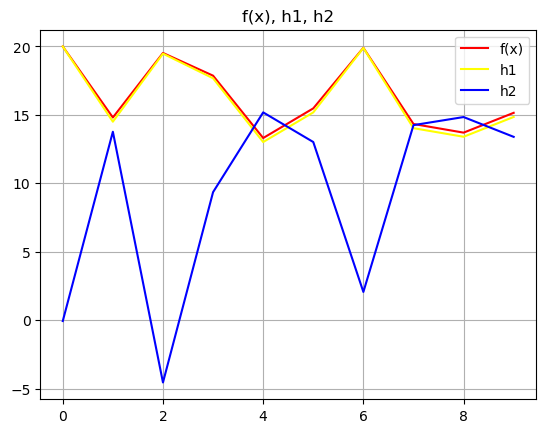

In [13]:
xi = np.random.uniform(-1, 3, 10)
print(f(xi))
plt.plot(f(xi), label='f(x)', color = 'red')
plt.plot(h1(xi), label='h1', color = 'yellow')
plt.plot(h2(xi), label='h2', color = 'blue')
plt.title('f(x), h1, h2')
plt.grid()
plt.legend()
plt.show()

h1 is much more closer to f(x)

f) How do your results compare to the basic estimate? Is this what you expect?

In [19]:
idx = ('Basic','h1', 'h2')

data_control_variate = {'integral_true': [integral_true],
        'integral_estimate': [result, result_control_variate_1, result_control_variate_2],
        'difference': [integral_true - result, integral_true - result_control_variate_1, integral_true - result_control_variate_2],
        'sigma^2_estimate/n': [variance, variance_control_variate_1, variance_control_variate_2],
        'sigma^estimate': [variance*n, variance_control_variate_1*n, variance_control_variate_2*n],
        }
df_control_variate = pd.DataFrame(data_control_variate, index = idx)


print(df_control_variate)

       integral_true  integral_estimate  difference  sigma^2_estimate/n  \
Basic      70.666667          70.602656    0.064011            0.001087   
h1         70.666667          70.668019   -0.001353            0.202541   
h2         70.666667          70.711884   -0.045217            0.013779   

       sigma^estimate  
Basic      108.694851  
h1       20254.091433  
h2        1377.862898  


According to the above, h1 is still better.

$$5.\; Importance\; Sampling$$

a) What is $\mathbb{E}p[I_n^{Importance}]$?

$I_n^{Importance} = \frac{1}{n}\sum\limits_{i=1}^n \frac{f(x_i)}{p(x_i)}$

b) Create a function to compute $I_n^{Importance}$ over an interval $a$, $b$ for number of samples $n$. The function signature should be:

In [14]:
def mc_importance(f: Callable[[float], float], a: float, b: float, n: int, sigma: float) -> tuple[float, float, float]:
    I_importance = 0
    var_importance = 0
   
   
    x_i = np.random.normal(loc = 0.0, scale = sigma, size = n)
    x_i_used = x_i[(x_i >= a) & (x_i<=b)]
    n_used = len(x_i_used)
    
    scaling_factor = norm.cdf(b, loc = 0, scale = sigma ) - norm.cdf(a, loc = 0, scale = sigma)
    
    p_x = norm.pdf(x_i_used, loc = 0, scale = sigma)
    p_scaled = p_x/scaling_factor

    f_x = [f(x_i) for x_i in x_i_used]
    term = [f_x[i]/p_scaled[i] for i in range(n_used)]
    sum_term = np.sum(term)
    I_importance = (1 / n_used) * sum_term
    var_importance = (1 / n_used) * np.var(term)

    return I_importance, var_importance, n_used

In [15]:
a = -1
b = 3
n = 100000


i_imp_l = []
var_imp_l = []
n_used_l = []
sigma_val = range(1,11)
for i in sigma_val:
    i_imp, var_imp,n_used = mc_importance(f,a,b,n,i)
    i_imp_l.append(i_imp)
    var_imp_l.append(var_imp)
    n_used_l.append(n_used)

sigma_estimate = [n_used_l[i]*var_imp_l[i] for i in range(len(n_used_l))]
difference = [integral_true - i_imp_l[i] for i in range(len(i_imp_l))]

c) Using $I_n^{Importance}$ $a = 1-$, $b = 3$ and 10 different normal distributions each with $\mu = 0$ and varying

In [16]:
idx = range(1,11)
data_basic = {'integral_true': integral_true,
        'integral_estimate': i_imp_l,
        'difference': difference,
        'sigma^2_estimate/n': var_imp_l,
        'sigma^estimate': sigma_estimate,
        'n_used': n_used_l
        }
df_basic = pd.DataFrame(data_basic, index = idx)

print(df_basic)

    integral_true  integral_estimate  difference  sigma^2_estimate/n  \
1       70.666667          70.802195   -0.135528            0.116565   
2       70.666667          70.679652   -0.012985            0.001833   
3       70.666667          70.674728   -0.008061            0.000033   
4       70.666667          70.641670    0.024997            0.000712   
5       70.666667          70.663823    0.002844            0.001626   
6       70.666667          70.705209   -0.038542            0.002522   
7       70.666667          70.687955   -0.021289            0.003327   
8       70.666667          70.704961   -0.038294            0.004202   
9       70.666667          70.754315   -0.087649            0.004921   
10      70.666667          70.776508   -0.109841            0.005689   

    sigma^estimate  n_used  
1      9814.667545   84199  
2       114.359081   62390  
3         1.563115   46992  
4        26.382758   37061  
5        49.271760   30302  
6        64.515063   25580  
7   

d) Which of the 10 importance sampling estimators is best? Why? Use a graph if you need to support your answer.

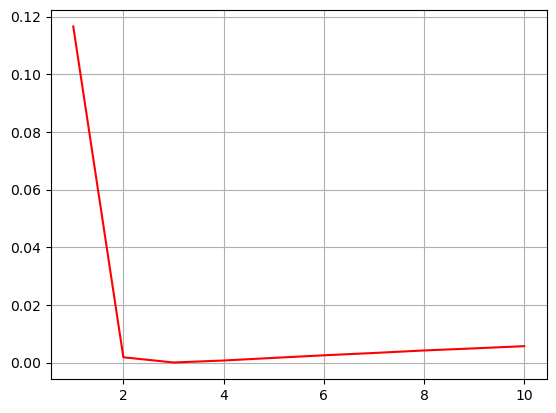

In [17]:
plt.plot(idx, var_imp_l, color = 'red')
plt.grid()


According to the data frame and graph above, 3 is the closest.

e) How do your results compare to the basic estimate? Is this what you expect?

In [18]:
idx = ["Basic", "Sigma_3"]
data_basic = {'integral_true': [integral_true],
        'integral_estimate': [result, i_imp_l[3]],
        'difference': [integral_true - result, integral_true - i_imp_l[3]],
        'sigma^2_estimate/n': [variance, var_imp_l[3]],
        'sigma^estimate': [variance*n, n_used_l[3]*var_imp_l[3]],
        }
df_basic = pd.DataFrame(data_basic, idx)

print(df_basic)

         integral_true  integral_estimate  difference  sigma^2_estimate/n  \
Basic        70.666667          70.602656    0.064011            0.001087   
Sigma_3      70.666667          70.641670    0.024997            0.000712   

         sigma^estimate  
Basic        108.694851  
Sigma_3       26.382758  
